## Model

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from models.beta_vae import BetaVAE
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Lambda
from pytorch_lightning import Trainer

imgs = pd.read_csv('data/mazes_2gf_continuous.csv', header=None).values

model = BetaVAE(
    in_channels=1,
    latent_dim=11,
    hidden_dims=[64, 128, 256, 512],
)


/home/leo/.python-envs/torch-gpu-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
imgs.shape

(30000, 171)

## Dataset

In [2]:
class MazeDataset_old(Dataset):
    
    img_size = 14

    def __init__(self, path2csv):
        self.imgs = pd.read_csv(path2csv).values
        self.transform = Lambda(lambda x: torch.Tensor(x.reshape(*self.get_size(x))))

    def __len__(self):
        return self.imgs.shape[0]
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.zeros(img.shape[0])

    def get_size(self, batch):
        if len(batch.shape) == 1:
            return (1, self.img_size, self.img_size)
        else:
            return (batch.shape[0], 1, self.img_size, self.img_size)

class MazeDataset(Dataset):
    
    img_size = 13

    def __init__(self, data):
        self.imgs = data
        self.transform = Lambda(lambda x: torch.Tensor(x.reshape(*self.get_size(x))))

    def __len__(self):
        return self.imgs.shape[0]
    
    def __getitem__(self, idx):
        img = self.imgs[idx, :-2]
        label = self.imgs[idx, -2:]
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_size(self, batch):
        if len(batch.shape) == 1:
            return (1, self.img_size, self.img_size)
        else:
            return (batch.shape[0], 1, self.img_size, self.img_size)


In [3]:
d = MazeDataset(imgs)

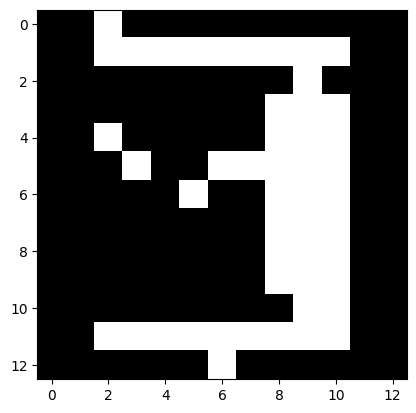

In [6]:
plt.imshow(d[17][0].squeeze(), cmap='binary');

In [6]:
d[0][0].shape

torch.Size([1, 13, 13])

In [7]:
model.forward(d[0:2][0])[0].shape

torch.Size([2, 1, 13, 13])

## Dataloaders

In [ ]:
d = MazeDataset(path2csv)
training_dataloader = DataLoader(d, batch_size=6, shuffle=True)
validation_dataloader = DataLoader(d, batch_size=16, shuffle=True)
test_dataloader = DataLoader(d[8000:], batch_size=16, shuffle=True)


In [ ]:
it = iter(validation_dataloader)

In [ ]:
a, b = next(it)

In [ ]:
a.shape

In [ ]:
b.shape

## Tensorboard


In [ ]:
%load_ext tensorboard

## Trained model

In [1]:
import torch
import yaml
from models.beta_vae import BetaVAE

# load pytorch model checkpoint from file
config_file = 'configs/bbvae.yaml'
with open(config_file, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


/home/leo/.python-envs/torch-gpu-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dataset import MazeDataset
import pandas as pd 
path2csv = 'data/mazes_2gf_continuous.csv'
imgs = pd.read_csv(path2csv, header=None).values
d = MazeDataset(imgs)

In [4]:
#from torchvision.datasets import MNIST
#from torchvision import transforms
#d = MNIST(root='data', train=0, download=True, transform=transforms.ToTensor())

In [5]:
model = BetaVAE(**config['model_params'])
state = torch.load('logs/BetaVAE/version_0/checkpoints/last.ckpt')['state_dict']

# remove 'model.' prefix from state dict keys
state = {k[6:]: v for k, v in state.items()} 

model.load_state_dict(state, strict=0) 
model.eval()

BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_m

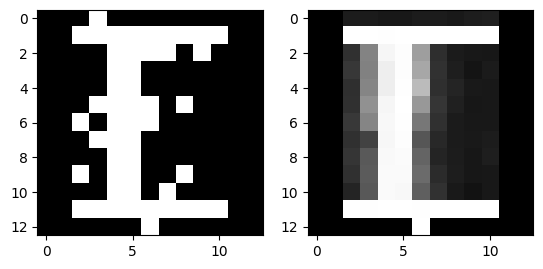

In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

idx = 7

# use this with mazes
in_ = d[idx:idx+1][0]
in_rec = model.generate(in_).squeeze().detach().numpy()

# use this with mnist
# in_ = d[idx][0]
# in_rec = model.generate(in_.reshape(1,*in_.shape)).squeeze().detach().numpy()

in_rec_thrd = np.where(in_rec > 0.45, 1, 0)
fig, axs = plt.subplots(1,2)
axs[0].imshow(in_.squeeze().detach().numpy(), cmap='binary')
axs[1].imshow(in_rec, cmap='binary')
fig.show()

In [7]:
idx = 198
in_ = d[idx:idx+1][0]

mu, log_var = model.encode(in_)
z = model.reparameterize(mu, log_var)

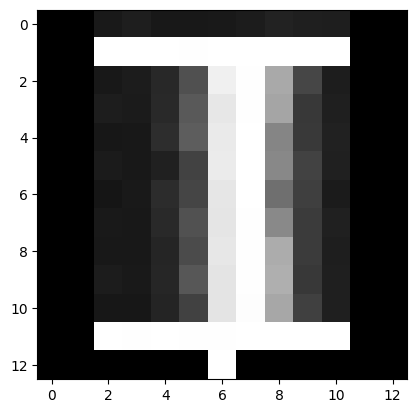

In [8]:
plt.imshow(model.decode(z).squeeze().detach().numpy(), cmap='binary');

In [9]:
z

tensor([[-1.2375,  1.0114]], grad_fn=<AddBackward0>)

In [15]:
# tensors of zeros with same shape as z
z_ = torch.zeros_like(z)
#rec = model.decode(z_)
#plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')

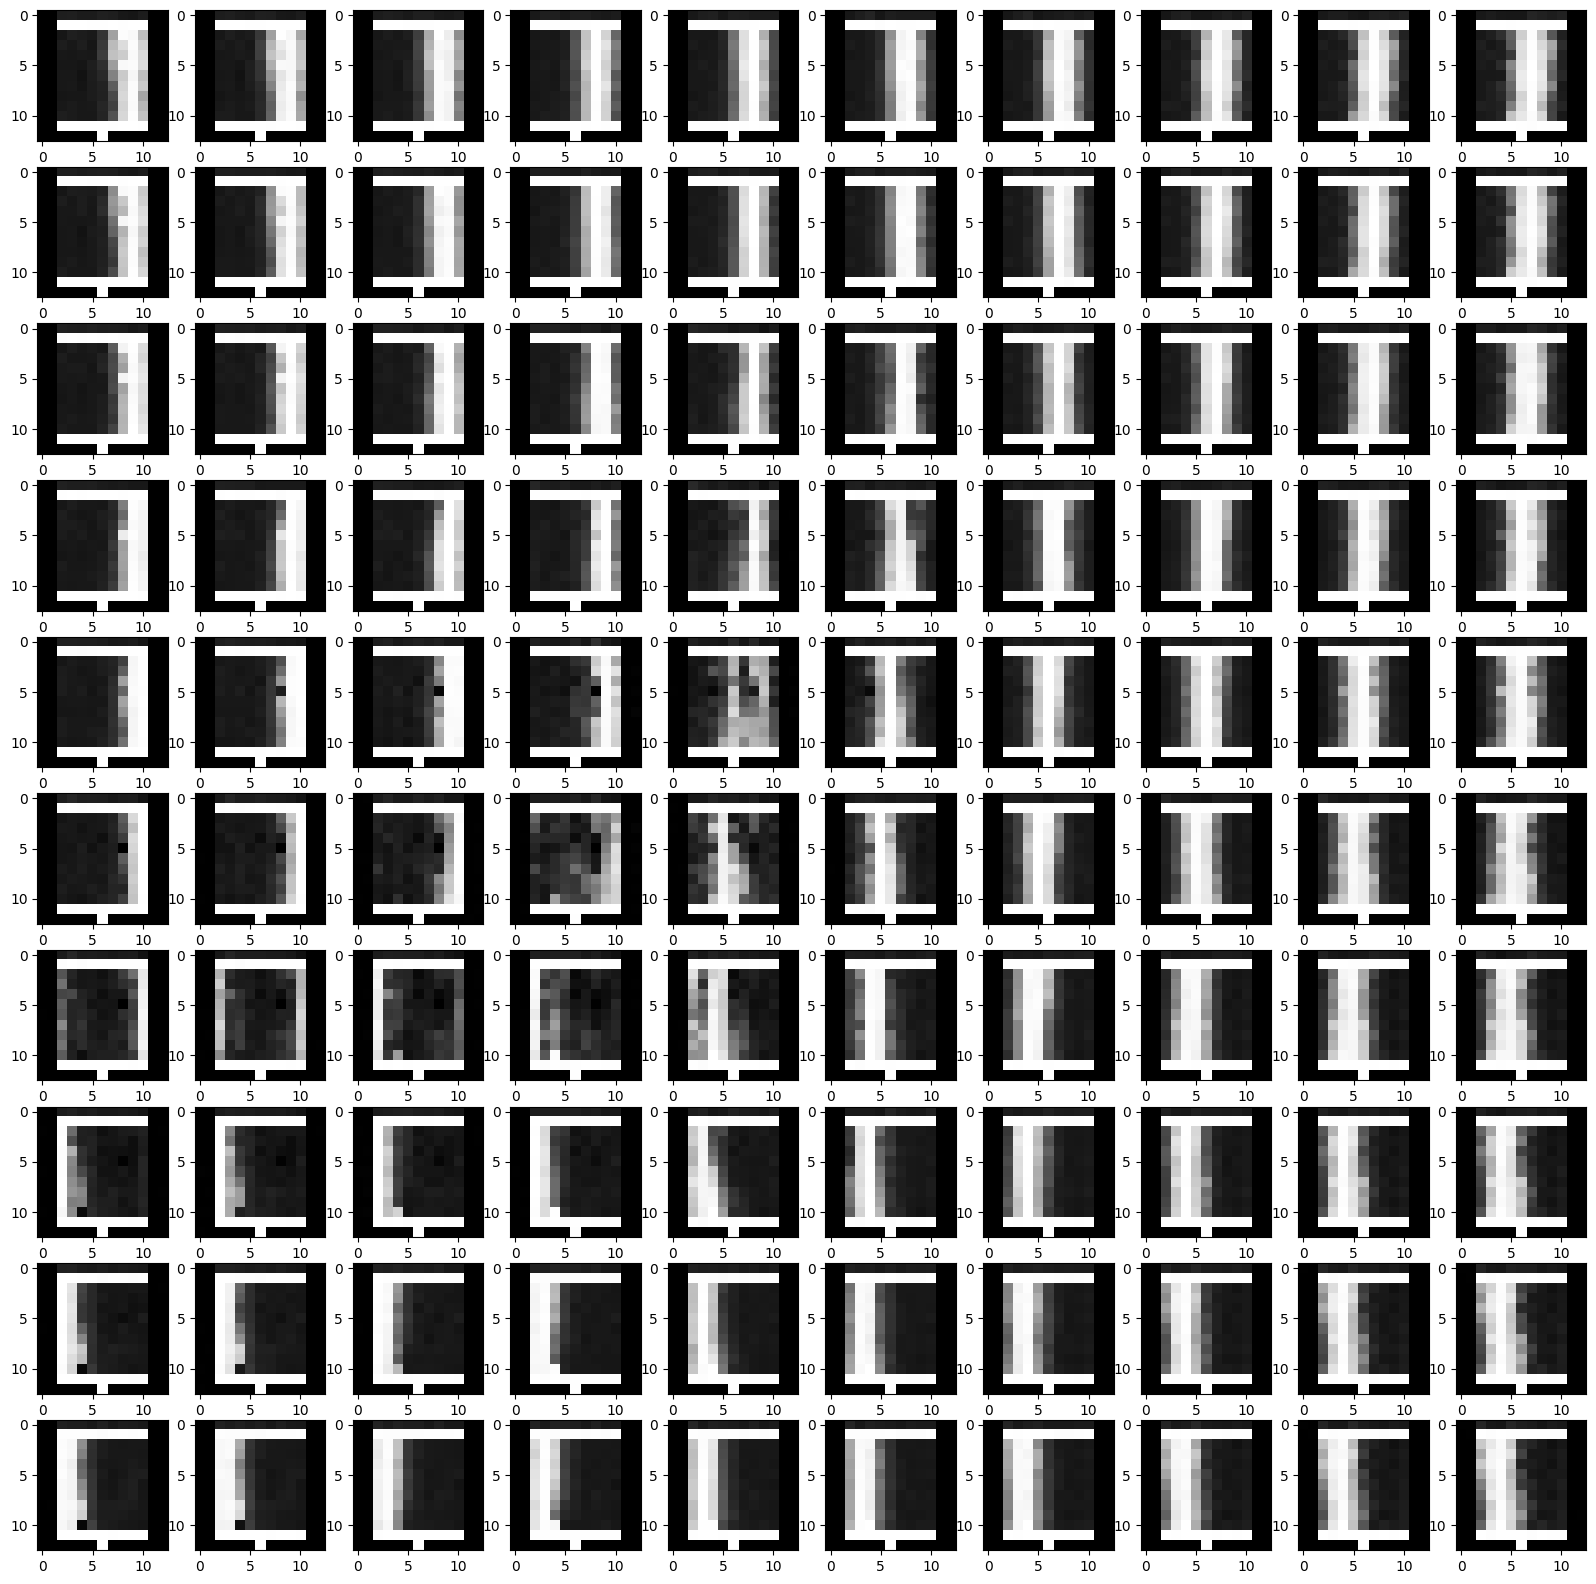

In [19]:
import numpy as np
import time

plt.figure(figsize=(20,20))
z = z_.clone()
c = 1
for i in np.linspace(-3, 3, 10):
    for j in np.linspace(-3, 3, 10):
        plt.subplot(10,10,c)
        z_ = z.clone()
        z_[:,0] = i
        z_[:,1] = j
        rec = model.decode(z_)
        plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')
        c += 1
plt.show()

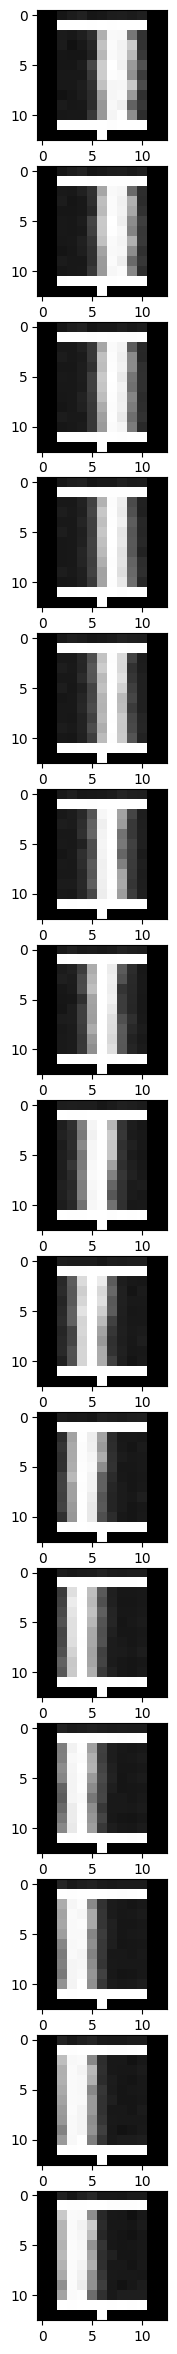

In [17]:
import numpy as np
import time

#z = z_.clone()
delta = 4
n_points = 15
latent_channel = 0

plt.figure(figsize=(10,2*n_points))
c = 1
for i in np.linspace(-delta,delta,n_points):
    plt.subplot(n_points,1,c)
    z_ = z.clone()
    z_[:,latent_channel] = i
    #z_[:,3] = j
    rec = model.decode(z_)
    plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')
    c += 1
plt.show()

In [ ]:
plt.imshow(d[0].squeeze(), cmap='binary'); 

In [ ]:
plt.imshow(imgs[1000].reshape(28,28), cmap='binary'); 

In [ ]:
a = torch.Tensor(imgs[0:5].reshape(5,1,28,28))
b = model.forward(a)

In [ ]:
b[0][0][0].shape

In [ ]:
plt.imshow(b[0][0].detach().numpy().reshape(28,28), cmap='binary')